In [1]:
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
import threading
import cv2
import os
import pandas as pd
import time 
import numpy as np
from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn.detector import MtcnnDetector

# importing the modules
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
detector = MtcnnDetector()


In [2]:
import torch
print(torch.__version__)
torch.cuda.is_available ()

1.12.1


True

In [2]:
data_csv = pd.read_csv("../train/label.csv")

In [ ]:
data_csv.head()


In [ ]:
print(data_csv["fname"])

In [14]:
len_of_lst = 160
shape_lst_image = (len_of_lst, 224, 224,3)
shape_image = (224, 224,3)
shape_facial = (len_of_lst,10)
range = shape_image[0] *shape_image[1]*shape_image[2]
print(shape_lst_image)

(160, 224, 224, 3)


In [12]:
def mask_detect(image):
    (h,w) = image.shape[:2]
    boxes, facial5points = detector.detect_faces(image)
    # print(facial5points)
    # print(type(facial5points))
    # print(facial5points.shape)
    face = np.zeros(shape =shape_image)
    point_facial =np.zeros(shape =(10))
    is_face = False
    if(len(boxes)!=0):
        point_facial = facial5points[0]
        is_face = True
        for box in boxes:
            (startX,startY,endX,endY)=box[:4].astype('int')
            #ensure the bounding boxes fall within the dimensions of the frame
            (startX,startY)=(max(0,startX),max(0,startY))
            (endX,endY)=(min(w-1,endX), min(h-1,endY))
            #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
            c=cv2.resize(image[startY:endY, startX:endX],(shape_image[0],shape_image[1]))
            face = c
            color = (255,0,0)
            cv2.rectangle(image,(startX,startY),(endX,endY),color,2)
    return image, face,point_facial, is_face

In [5]:

def get_sim_matrix(lst_img):
    lst_reshape = lst_img.reshape(len_of_lst,range)
    list_sim = cosine_similarity(lst_reshape, lst_reshape)
    return list_sim

In [16]:
def PlayCamera(id):    
    num_of_face = 0
    num_of_face_not_null = 0
    video_capture = cv2.VideoCapture(id)
    face = None
    width  = int(video_capture.get(3))
    height = int(video_capture.get(4))
    if height > width:
        scale = height / width
    else:
        scale = width / height
    while height>1000 or width>1000: 
        height = int(height/scale)
        width = int(width/scale)

    list_face = np.zeros(shape = shape_lst_image, dtype=np.uint8)
    list_face_not_null = np.zeros(shape = shape_lst_image, dtype=np.uint8)
    list_face_point = np.zeros(shape = shape_facial, dtype=np.uint8)
    list_face_point_not_null = np.zeros(shape = shape_facial, dtype=np.uint8)
    while True:
        ret, frame = video_capture.read()
        frame = cv2.resize(frame,(width,height))
        img, face, point_facial,is_face = mask_detect(frame)
        if(len_of_lst>num_of_face):
            list_face[num_of_face] = face
            list_face_point[num_of_face] = point_facial
            if(is_face):
                list_face_not_null[num_of_face_not_null] = face
                list_face_point_not_null[num_of_face_not_null]
                num_of_face_not_null +=1
            num_of_face +=1      
        cv2.imshow("img",frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            video_capture.release()
            cv2.destroyAllWindows()
            break
            
    video_capture.release()
    cv2.destroyAllWindows()
    return list_face, list_face_not_null,list_face_point,list_face_point_not_null

In [39]:
name_dataset = "../train/videos/"


In [17]:
def get_embeded(data_csv):
    lst_out= []
    lst_out_notnull = []
    for name in data_csv["fname"]:
        scr = name_dataset + name
        x,x_notnull = PlayCamera(scr)
        sim_embed = get_sim_matrix(x)
        sim_embed_notnull = get_sim_matrix(x_notnull)
        lst_out.append(sim_embed)
        lst_out_notnull.append(sim_embed_notnull)
    data_csv["embed"] = lst_out
    data_csv["embed_notnull"] = lst_out_notnull
    return data_csv,lst_out

[[175.94334 229.44653 204.13083 185.25943 226.86893 426.11685 426.42316
  460.14935 480.4351  476.73495]]
<class 'numpy.ndarray'>
(1, 10)
[[183.14859 230.93347 210.08888 182.35474 228.66873 427.28436 426.09714
  452.7557  476.44705 474.67822]]
<class 'numpy.ndarray'>
(1, 10)
[[182.25446 229.63643 208.95074 176.96408 220.51604 424.27078 426.25616
  456.68475 473.69513 477.70267]]
<class 'numpy.ndarray'>
(1, 10)
[[176.49629 227.11882 206.05391 175.13138 223.59534 436.88712 434.70636
  462.68283 484.85043 486.2354 ]]
<class 'numpy.ndarray'>
(1, 10)
[[174.40462 229.60919 203.90425 188.94615 223.84291 431.01443 428.287
  463.86264 488.39694 487.25873]]
<class 'numpy.ndarray'>
(1, 10)
[[178.32443 226.86311 212.43843 185.38423 227.22945 429.85065 425.74426
  456.32214 483.3462  479.76343]]
<class 'numpy.ndarray'>
(1, 10)
[[175.16592 223.88129 202.8247  174.76639 224.8446  429.89038 425.64133
  460.70767 472.84253 473.2603 ]]
<class 'numpy.ndarray'>
(1, 10)
[[178.14114 228.08803 204.9685  187.

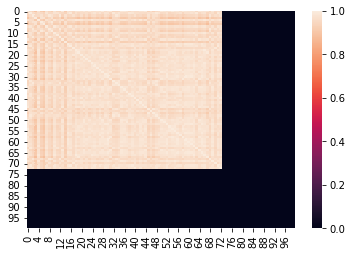

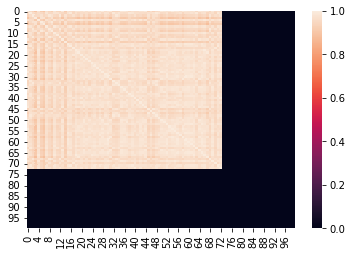

In [19]:
id = "../train/videos/71.mp4"
list_face, list_face_not_null, list_face_point,list_face_point_not_null = PlayCamera(id)
cv2.destroyAllWindows()
out = get_sim_matrix(list_face)
out_not_null = get_sim_matrix(list_face_not_null)
lst = [out,out_not_null]
for m in lst:
    hm = sn.heatmap(data = m[:100,:100])
    plt.show()

In [20]:
print(list_face_point.shape)

(160, 10)


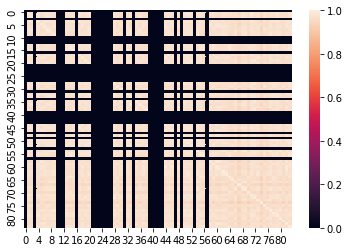

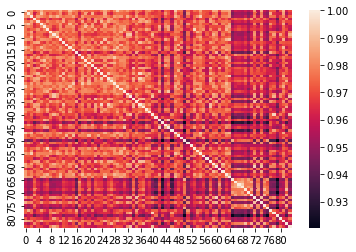

In [86]:
for m in lst:
    hm = sn.heatmap(data = m[:84,:84])
    plt.show()

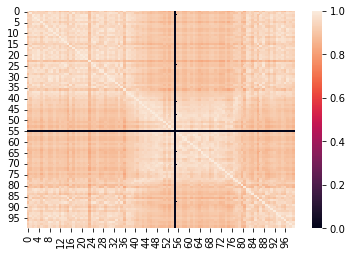

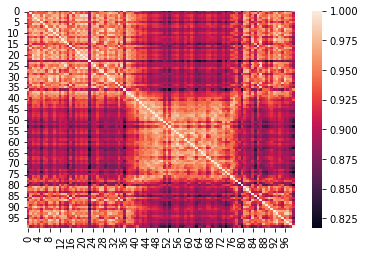

In [78]:
id = "../train/videos/1.mp4"
list_face2, list_face_not_null2 = PlayCamera(id)
cv2.destroyAllWindows()
out2 = get_sim_matrix(list_face2)
out_not_null2 = get_sim_matrix(list_face_not_null2)
lst = [out2,out_not_null2]
for m in lst:
    hm = sn.heatmap(data = m[:100,:100])
    plt.show()

In [ ]:
hm = sn.heatmap(data = out[:100,:100])
plt.show()

In [17]:
print(lsst2.sum())

493691673


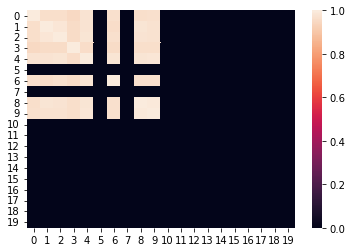

In [62]:
id = "../train_avi/videos/3.mp4"
lsst1 = PlayCamera(id)
cv2.destroyAllWindows()
out2 = get_sim_matrix(lsst1)
hm = sn.heatmap(data = out2[:20,:20])
plt.show()

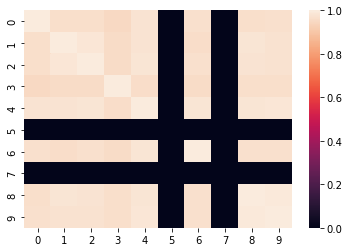

In [63]:
hm = sn.heatmap(data = out2[:10,:10])
plt.show()

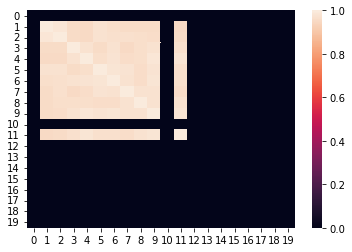

In [30]:
hm = sn.heatmap(data = out2[:20,:20])
plt.show()

In [51]:
cv2.destroyAllWindows()

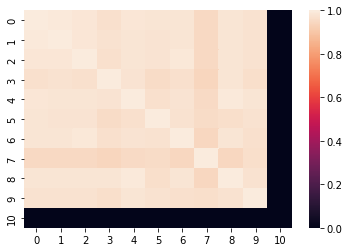

In [24]:
# rnet
hm = sn.heatmap(data = out2[:20,:20])
plt.show()

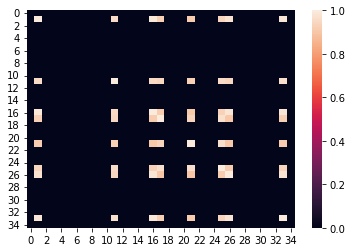

In [25]:
hm = sn.heatmap(data = out[:35,:35])
plt.show()

In [ ]:
lst_out = []
lst_out.append({
    "name":"test",
    "embed": out
})
data = pd.DataFrame(lst_out)

In [ ]:
x = data["embed"].values[0]
print(type(x))

In [ ]:
cv2.imshow("img",lsst[1])
cv2.waitKey(0) 
cv2.destroyAllWindows()

In [ ]:
cv2.destroyAllWindows()

In [ ]:
# video_capture.release()

In [ ]:
# id = "../train/videos/1.mp4"
# video_capture = cv2.VideoCapture(id)
# num = 0
# while True:
    
#     ret, frame = video_capture.read()
#     num += 1
#     img, face = mask_detect(frame)

#     cv2.imshow('{}'.format(id), img)        
#     if cv2.waitKey(1) & 0xFF == ord('q'):
        

#         break
    
# print(num)
# PlayCamera()

In [ ]:
#Convert to AVI
# import imageio
# src_dir = "../train/videos/"
# dest_dir = "../train_avi/videos/"
# lstmp4 = os.listdir(src_dir)

# for file in lstmp4:
#     scr = src_dir+file
    
#     des = dest_dir + file
    
#     reader = imageio.get_reader(scr)
#     fps = reader.get_meta_data()['fps']
#     writer = imageio.get_writer(des, fps=fps)

#     for im in reader:
#         writer.append_data(im[:, :, :])
#     writer.close()

In [ ]:
img1 = cv2.imread("Truyen_small.png")
img2 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(img1,100,200)
img_zero = np.zeros(shape =(img1.shape[0],img1.shape[1],3))
x = cosine_similarity(np.array([lsst[1].reshape(-1)]), np.array([lsst[59].reshape(-1)]))


In [ ]:
print(x)

In [ ]:
print(lst[0][0,1])
print(lsst[0,0,1])

In [ ]:
print(img1.shape)

In [ ]:
cv2.imshow("x",edges)
cv2.waitKey(0)
cv2.destroyAllWindows()